In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from cobaya.model import get_model
import healpy as hp
from astropy.io import fits

from IPython.display import display, Math
import matplotlib.pyplot as plt
#from matplotlib_inline.backend_inline import set_matplotlib_formats
from astropy.visualization import quantity_support
from tqdm import tqdm

quantity_support()
#set_matplotlib_formats('svg')
from matplotlib import cm
from cycler import cycler
plt.rc('legend', frameon = False)
plt.rc('figure', figsize = (7, 7/1.25))
plt.rc('font', size = 14)

In [2]:
noise = fits.open('tod_070_rms_c0001_k000797_2rms.fits')
noise_data = noise[1].data
noise_temp = noise_data['TEMPERATURE'].flatten()
noise_q    = noise_data['Q_POLARISATION'].flatten()
noise_u    = noise_data['U_POLARISATION'].flatten()

sigma_T = noise_temp.mean()/1e6 #why is this divided by 1e6?
sigma_P = noise_q.mean()/1e6 
#why no sigma_U?

N_l_T = sigma_T**2 * hp.nside2pixarea(1024) 
N_l_Q = sigma_P**2 * hp.nside2pixarea(1024)
N_l_U = sigma_P**2 * hp.nside2pixarea(1024)

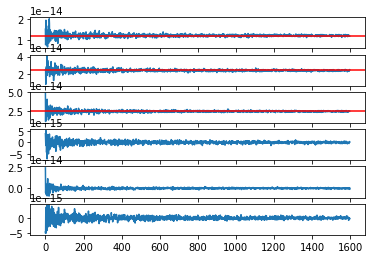

In [3]:
#isotropic noise
noise_temp = sigma_T * np.random.normal(0, 1, len(noise_temp))
noise_q = sigma_P * np.random.normal(0, 1, len(noise_q))
noise_u = sigma_P * np.random.normal(0, 1, len(noise_u))

Nls = hp.sphtfunc.anafast([noise_temp, noise_q, noise_u], lmax = 1600)
Nl_tt = Nls[0]
Nl_ee = Nls[1]
Nl_bb = Nls[2]
Nl_te = Nls[3]
Nl_eb = Nls[4]
Nl_tb = Nls[5]


fig, axes = plt.subplots(sharex=True, nrows=6)
for i in range(6):
    axes[i].plot(Nls[i][2:])
axes[0].axhline(N_l_T, color='r')
axes[1].axhline(N_l_Q, color='r')
axes[2].axhline(N_l_U, color='r')

plt.show()

In [4]:
#load beam data
beam = fits.open('Bl_TEB_npipe6v19_70GHzx70GHz.fits')[1]
#get pixel window
pixel_window_T, pixel_window_P = np.array(hp.sphtfunc.pixwin(nside = 1024, pol = True, lmax = 1600))

func_tt = (beam.data['T'][:1601] * pixel_window_T)**2
func_ee = (beam.data['E'][:1601] * pixel_window_P)**2
func_bb = (beam.data['B'][:1601] * pixel_window_P)**2
func_te = pixel_window_T * pixel_window_P * beam.data['T'][:1601] * beam.data['E'][:1601]
func_eb = pixel_window_P**2 * beam.data['E'][:1601] * beam.data['B'][:1601]
func_tb = pixel_window_T * pixel_window_P * beam.data['T'][:1601] * beam.data['B'][:1601]

## Thing I changed

Added the noise realization in map space instead of power spectrum space.

Also, the equation $N_l=\sigma^2$ (after unit conversions, this is true...) means you're putting a _model_ of the noise spectrum, not the noise spectrum itself.

[camb] `camb` module loaded successfully from /mn/stornext/d16/cmbco/bp/kat/cobaya/cobaya/likelihoods/code/CAMB/camb
[model] *WARNING* Theories {camb.transfers, camb} do not appear to be actually used for anything
[healpy] Sigma is 0.000000 arcmin (0.000000 rad) 
[healpy] -> fwhm is 0.000000 arcmin


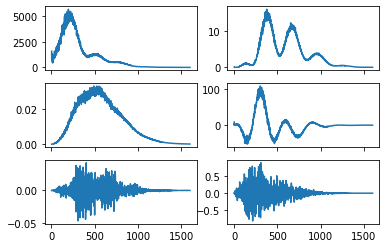

In [5]:
#simulate CMB with cobaya so I can make a new realization of it
fiducial_params = {
    'ombh2': 0.02237, 'omch2': 0.12, 'H0': 67.36, 'tau': 0.0544,
    'As': 2.1e-9, 'ns': 0.9649}

l_max = 1600

packages_path = '/mn/stornext/d16/cmbco/bp/kat/cobaya/cobaya/likelihoods'

info_fiducial = {
    'params': fiducial_params,
    'likelihood': {'one': None},
    'theory': {'camb': {'stop_at_error': True}},
    'packages_path': packages_path}

from cobaya.model import get_model
model_fiducial = get_model(info_fiducial)

# Declare our desired theory product
# (there is no cosmological likelihood doing it for us)
model_fiducial.add_requirements({"Cl": {'tt': l_max, 'ee': l_max, 'bb': l_max, 
                                        'te': l_max}})

# Compute and extract the CMB power spectrum
# (In muK^-2, without l(l+1)/(2pi) factor)
# notice the empty dictionary below: all parameters are fixed
model_fiducial.logposterior({})
Cls = model_fiducial.provider.get_Cl(ell_factor=False, units="muK2")

# power spectrum
Cl_tt = Cls['tt'][:l_max + 1]
Cl_ee = Cls['ee'][:l_max + 1]
Cl_bb = Cls['bb'][:l_max + 1]
Cl_te = Cls['te'][:l_max + 1]

#make realization
#map_sim = hp.sphtfunc.synfast((Cl_tt, Cl_te, Cl_ee, Cl_bb), 1024, pixwin=True)

alm_sim = hp.synalm((Cl_tt, Cl_te, Cl_ee, Cl_bb), lmax=1600)
alm_sim[0] = hp.almxfl(alm_sim[0], beam.data['T'][:1601])
alm_sim[1] = hp.almxfl(alm_sim[1], beam.data['E'][:1601])
alm_sim[2] = hp.almxfl(alm_sim[2], beam.data['B'][:1601])
map_sim = hp.alm2map(alm_sim, 1024, pixwin=True)
map_sim[0] += noise_temp #isotropic noise
map_sim[1] += noise_q
map_sim[2] += noise_u
Cls = hp.sphtfunc.anafast(map_sim, nspec = 6, lmax = l_max)

#add noise
# it is now added in map space above
Cl_tt = Cls[0]# + Nl_tt
Cl_ee = Cls[1]# + Nl_ee
Cl_bb = Cls[2]# + Nl_bb
Cl_te = Cls[3]
Cl_eb = np.zeros(l_max+1)
Cl_tb = np.zeros(l_max+1)

"""
#bin
bins = np.geomspace(1000, l_max, dtype = int)
for i in range(1, len(bins)):
    Cl_tt[bins[i-1]:bins[i]] = np.mean(Cl_tt[bins[i-1]:bins[i]])
    Cl_ee[bins[i-1]:bins[i]] = np.mean(Cl_ee[bins[i-1]:bins[i]])
    Cl_bb[bins[i-1]:bins[i]] = np.mean(Cl_bb[bins[i-1]:bins[i]])
    Cl_te[bins[i-1]:bins[i]] = np.mean(Cl_te[bins[i-1]:bins[i]])
    Cl_eb[bins[i-1]:bins[i]] = np.mean(Cl_eb[bins[i-1]:bins[i]])
    Cl_tb[bins[i-1]:bins[i]] = np.mean(Cl_tb[bins[i-1]:bins[i]])
"""

fig, axes = plt.subplots(sharex=True, nrows=3, ncols=2)
axs = axes.flatten()
ells = np.arange(l_max+1)
ell_factor = ells*(ells+1)/(2*np.pi)
for i in range(len(Cls)):
    axs[i].plot(ells[2:], (Cls[i]*ell_factor)[2:])

In [6]:
def all_like(_self=None):
    ells = np.arange(l_max+1)
    
    Cls_camb = _self.provider.get_Cl(ell_factor=False, units = "muK2")
    camb_tt = Cls_camb['tt'][:l_max+1]*func_tt
    camb_ee = Cls_camb['ee'][:l_max+1]*func_ee
    camb_bb = Cls_camb['bb'][:l_max+1]*func_bb
    camb_te = Cls_camb['te'][:l_max+1]*func_te
    
    Cls_map = np.zeros((l_max+1, 3, 3))
    Cls_map_theo = np.zeros((l_max+1, 3, 3))
    for ell in range(l_max+1):
        Cls_map[ell] = np.array([[Cl_tt[ell], Cl_te[ell], Cl_tb[ell]],
                                 [Cl_te[ell], Cl_ee[ell], Cl_eb[ell]],
                                 [Cl_tb[ell], Cl_eb[ell], Cl_bb[ell]]])
        Cls_map_theo[ell] = np.array([[camb_tt[ell] + N_l_T, camb_te[ell],              0.                       ],
                                      [camb_te[ell],              camb_ee[ell] + N_l_Q, 0.                       ],
                                      [0.,                        0.,                        camb_bb[ell] + N_l_U]])
    """
    bins = np.geomspace(1000, l_max, dtype = int)
    for i in range(1, len(bins)):
        Cls_map_theo[bins[i-1]:bins[i]] = np.mean(Cls_map_theo[bins[i-1]:bins[i]], axis = 0)
        Nls_map[bins[i-1]:bins[i]]      = np.mean(Nls_map[bins[i-1]:bins[i]], axis = 0)
    """
    
    if _do_plot:
        ell_factor = ells*(ells+1)/(2*np.pi)
        fig, axes = plt.subplots(figsize = (7*1.25, 7), nrows=2, ncols=2, sharex=True)
        axs = axes.flatten()
        axs[0].loglog(ells[2:], (Cl_tt*ell_factor)[2:], label=r'Original $C_\ell$ with noise')
        axs[0].plot(ells[2:], ((camb_tt + N_l_T)*ell_factor)[2:], label=r'Theory $C_\ell$ with noise')
        axs[0].set_title("TT")
        
        axs[1].loglog(ells[2:], (Cl_ee*ell_factor)[2:], label=r'Original $C_\ell$ with noise')
        axs[1].plot(ells[2:], ((camb_ee + N_l_Q)*ell_factor)[2:], label=r'Theory $C_\ell$ with noise')
        axs[1].set_title("EE")
        
        axs[2].loglog(ells[2:], (Cl_bb*ell_factor)[2:], label=r'Original $C_\ell$ with noise')
        axs[2].plot(ells[2:], ((camb_bb + N_l_Q)*ell_factor)[2:], label=r'Theory $C_\ell$ with noise')
        axs[2].set_title("BB")
        
        axs[3].plot(ells[2:], (Cl_te*ell_factor)[2:], label=r'Original $C_\ell$ with noise')
        axs[3].plot(ells[2:], ((camb_te)*ell_factor)[2:], label=r'Theory $C_\ell$ with noise')
        axs[3].set_title("TE")
        #plt.yscale("log")
        #plt.xscale("log")
        plt.show()

        
    logp = 0
    for ell in range(2, l_max+1):
        # Slogdet is signed log determinant
        lndet1 = (2*ell-3)/2*np.linalg.slogdet(Cls_map[ell])[1]
        lndet2 = (2*ell+1)/2*np.linalg.slogdet(Cls_map_theo[ell])[1]
        Tr = (2*ell+1)/2*np.trace(Cls_map[ell].dot(np.linalg.inv(Cls_map_theo[ell])))
        logp += lndet1 - lndet2 - Tr
    return logp


In [7]:
l_max = 1600
info_generator = {'likelihood': {'all_like': {'external': all_like, 
                                              'requires': {'Cl': {'tt': l_max, 'ee': l_max, 
                                                                 'bb': l_max, 'te': l_max}},
                                              'stop_at_error': True}},
                  
                  'params': {
                             #Fixed
                             'ombh2': 0.02237, 'omch2': 0.12, 'H0': 67.36, 'tau': 0.0544, 
                             #'mnu': 0.06, 'nnu': 3.046, 
                             #'theta_MC_100': 0.01, 
                      
                             #Sampled
                             #'ombh2': {'latex': '\\Omega_\\mathrm{b} h^2',
                             #          'prior': {'max': 0.1, 'min': 0.005},
                             #          'proposal': 0.0001,
                             #          'ref': {'dist': 'norm', 'loc': 0.0224, 'scale': 0.0001}},
                             #'omch2': {'latex': '\\Omega_\\mathrm{c} h^2',
                             #          'prior': {'max': 0.99, 'min': 0.001},
                             #          'proposal': 0.0005,
                             #          'ref': {'dist': 'norm', 'loc': 0.12, 'scale': 0.001}},
                             #'H0': {'latex': 'H_0', 
                             #       'prior': {'max': 100, 'min': 40},
                             #       'ref': {'dist': 'norm', 'loc': 70, 'scale': 2}, 
                             #       'proposal': 2},
                             #'tau': {'latex': '\\tau_\\mathrm{reio}',
                             #        'prior': {'max': 0.8, 'min': 0.01},
                             #        'proposal': 0.003,
                             #        'ref': {'dist': 'norm', 'loc': 0.055, 'scale': 0.006}},
                             'As': {'latex': 'A_\\mathrm{s}', 
                                    'prior': {'min': 1e-9, 'max': 4e-9}, 
                                    'ref': {'dist': 'norm', 'loc': 2e-9, 'scale': 0.05e-9}}, #this is the only thing I have added or changed
                             #'logA': {'drop': True, 
                             #         'latex': '\\log(10^{10} A_\\mathrm{s})',
                             #         'prior': {'max': 3.91, 'min': 1.61},
                             #         'proposal': 0.001,
                             #         'ref': {'dist': 'norm', 'loc': 3.05, 'scale': 0.001}},
                             'ns': {'latex': 'n_\\mathrm{s}',
                                    'prior': {'max': 1.2, 'min': 0.1},
                                    'proposal': 0.002,
                                    'ref': {'dist': 'norm', 'loc': 0.965, 'scale': 0.004}},
                             #'theta_MC_100': {'drop': True,
                             #                 'latex': '100\\theta_\\mathrm{MC}',
                             #                 'prior': {'max': 10, 'min': 0.5},
                             #                 'proposal': 0.0002,
                             #                 'ref': {'dist': 'norm', 'loc': 1.04109, 'scale': 0.0004},
                             #                 'renames': 'theta'},
                      
                             #Derived
                             'A': {'derived': 'lambda As: 1e9*As',
                                   'latex': '10^9 A_\\mathrm{s}'},
                             #'As': {'latex': 'A_\\mathrm{s}',
                             #       'value': 'lambda logA: 1e-10*np.exp(logA)'},
                      
                             #Unsure whether I need these
                             #gonna say I don't cause they're all derived
                             #'DHBBN': {'derived': 'lambda DH: 10**5*DH',
                             #          'latex': '10^5 \\mathrm{D}/\\mathrm{H}'},
                             #'YHe': {'latex': 'Y_\\mathrm{P}'},
                             #'Y_p': {'latex': 'Y_P^\\mathrm{BBN}'},
                             #'age': {'latex': '{\\rm{Age}}/\\mathrm{Gyr}'},
                             #'clamp': {'derived': 'lambda As, tau: 1e9*As*np.exp(-2*tau)',
                             #          'latex': '10^9 A_\\mathrm{s} e^{-2\\tau}'},
                             #'cosmomc_theta': {'derived': False,
                             #                  'value': 'lambda theta_MC_100: '
                             #                  '1.e-2*theta_MC_100'},
                             #'omega_de': {'latex': '\\Omega_\\Lambda'},
                             #'omegam': {'latex': '\\Omega_\\mathrm{m}'},
                             #'omegamh2': {'derived': 'lambda omegam, H0: omegam*(H0/100)**2',
                             #             'latex': '\\Omega_\\mathrm{m} h^2'},
                             #'rdrag': {'latex': 'r_\\mathrm{drag}'},
                             #'s8h5': {'derived': 'lambda sigma8, H0: sigma8*(H0*1e-2)**(-0.5)',
                             #         'latex': '\\sigma_8/h^{0.5}'},
                             #'s8omegamp25': {'derived': 'lambda sigma8, omegam: '
                             #                'sigma8*omegam**0.25',
                             #                'latex': '\\sigma_8 \\Omega_\\mathrm{m}^{0.25}'},
                             #'s8omegamp5': {'derived': 'lambda sigma8, omegam: '
                             #               'sigma8*omegam**0.5',
                             #               'latex': '\\sigma_8 \\Omega_\\mathrm{m}^{0.5}'},
                             #'sigma8': {'latex': '\\sigma_8'},
                             #'zrei': {'latex': 'z_\\mathrm{re}'}
                             },
                  
                  'theory': {'camb': {'stop_at_error': True}},
                  #deleting the fancy extra arguments from camb
                  #'theory': {'camb': {'extra_args': {'bbn_predictor': 'PArthENoPE_880.2_standard.dat',
                  #                                   'halofit_version': 'mead',
                  #                                   'lens_potential_accuracy': 1,
                  #                                   'nnu': 3.046,
                  #                                   'num_massive_neutrinos': 1,
                  #                                   'theta_H0_range': [20, 100]}}},
                  'packages_path': '/mn/stornext/d16/cmbco/bp/kat/cobaya/cobaya/likelihoods' 
                  #'debug': True
                 }

model_all = get_model(info_generator)
#print(list(model_tt.parameterization.sampled_params()))

[camb] `camb` module loaded successfully from /mn/stornext/d16/cmbco/bp/kat/cobaya/cobaya/likelihoods/code/CAMB/camb
[all_like] Initialized external likelihood.


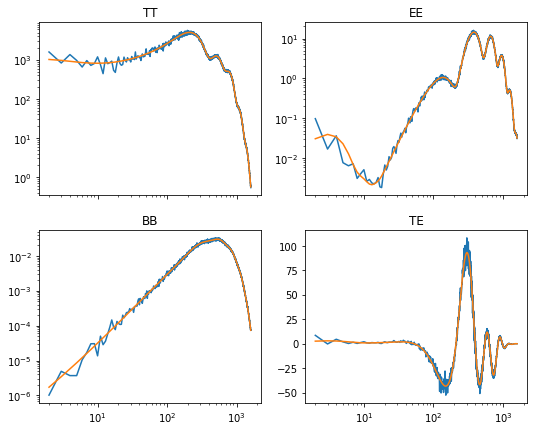

In [8]:
# Eval likelihood once with fid values and plot
_do_plot = True
#_plot_name = "fiducial.png"
fiducial_params = {
    'ombh2': 0.02237, 'omch2': 0.12, 'H0': 67.36, 'tau': 0.0544,
    'As': 2.1e-9, 'ns': 0.9649}
model_all.logposterior(fiducial_params)
_do_plot = False

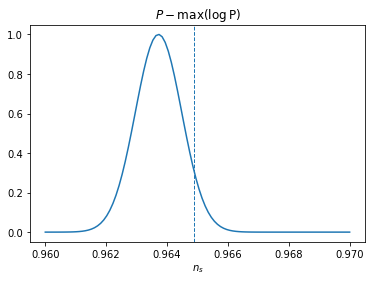

In [9]:
# Plot of (prpto) probability density
As = np.linspace(1.5e-9, 2.5e-9, 10)
ns = np.linspace(0.96, 0.97, 100) #bad
#ombh = np.linspace(0.01, 0.03, 10)
#omch = np.linspace(0.1, 0.2, 10)
#Hs = np.linspace(65, 70, 10) #bad
#ts = np.linspace(0.04, 0.06, 10) #bad

loglikes = [model_all.loglike({'As': 2.1e-9, 'ns': n, 
                              'ombh2': 0.02237, 'omch2': 0.12,
                              'H0': 67.36, 'tau': 0.0544})[0] for n in ns]

plt.figure()
plt.plot(ns, np.exp(loglikes - np.max(loglikes)))
plt.axvline(0.9649, ls = '--', lw = 1)
#plt.axhline(-2, ls = '--', lw = 1)
#plt.gca().get_yaxis().set_visible(False)
plt.title(r"$P - \rm{max}(\log P)$")
plt.xlabel(r"$n_s$")
plt.show()